# Utility Section

Imports

In [1]:
# Import
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Iterable, Tuple

Utils class

In [22]:
# Utility class for HW_3
class Utils():
    
    __X = None
    __Y = None
    
    def sigmoid(z: np.ndarray) -> Iterable[float]:
        if z is None:
            return None
        return 1/(1 + np.exp(-z))
    
    def cost_function(weights: np.ndarray, 
                      dataset: pd.DataFrame,
                      alpha: float,
                      _lambda: float = 0.0) -> Tuple[float, np.ndarray]:
        """
        Method to calculate Cost Function and new weights for a logistic regression 
        model with Gradient-Descent [GD] algorithm.

        Args:
            weights [type: np.array]: initial weights value.
            dataset [type: pd.DataFrame]: data set for linear regression.
            alpha [type: float]: GD learning rate.
            _lambda [type: float]: regularization factor. default as 0.1.

        Raises:
            1. Exception: Failed to calculate hypothesis for input file.

        Returns:
            cost, gradient [type: Tuple[float, np.ndarray]]: cost value and gradient update
                                                             for a single GD step.
        """
        x = Utils.get_x_vals(dataset)
        y = Utils.get_y_vals(dataset, x) 
        h = Utils.sigmoid(np.dot(Utils.__X, weights))
        m = y.shape[0]
        cost_1 = y*np.log(h+0.01)
        cost_0 = (1-y)*np.log(1-h+0.01)
        regul = (_lambda/2*m)*np.sum(weights**2)
        cost = -(1/m) * np.sum(cost_1 + cost_0) + regul
        gradient = Utils.__gradient(h, x, y, weights, alpha, _lambda)
        return float(cost), gradient

    def get_init_weights(dataset: pd.DataFrame, use_dataset_dim: bool) -> np.ndarray:
        n = dataset.shape[1] if use_dataset_dim else len(Utils.__X[0])
        weights = 1000*np.ones((n, 1), dtype=np.float64)
        return weights

    def reset_variables() -> None:
        Utils.__X = None
        Utils.__Y = None

    def check_convergence(last_cost: float, new_cost: float, asc_threshold: float, epsilon: float) -> bool:
        ascending = new_cost - last_cost > asc_threshold
        ascending_err_msg = f'Cost function ascending detected!\n' +\
                            f'New cost: {new_cost}, Last cost: {last_cost}'
        if ascending: raise Exception(ascending_err_msg)
        step_change = np.abs(last_cost-new_cost)
        is_converge = step_change < epsilon
        return is_converge

    def set_x_vals(x: np.ndarray) -> None:
        Utils.__X = x
    
    def set_y_vals(y: np.ndarray) -> None:
        Utils.__Y = y

    def get_x_vals(dataset: pd.DataFrame, add_x0: bool=True) -> np.ndarray:
        if Utils.__X is None:
            x = dataset.iloc[:,:-1]
            if add_x0:
                ones = np.ones((x.shape[0], 1)) 
                x = np.concatenate((ones, x), axis=1)
            Utils.__X = x
        return Utils.__X

    def get_y_vals(dataset: pd.DataFrame, x: np.ndarray) -> np.ndarray:
        if Utils.__Y is None:
            y = np.array(dataset.iloc[:,-1])
            y = y.reshape(x.shape[0], 1)
            Utils.__Y = y
        return Utils.__Y

    def __gradient(h: np.ndarray, 
                   x: np.ndarray, 
                   y: np.ndarray,
                   weights: np.ndarray,
                   alpha: float,
                   _lambda: float) -> np.ndarray:
        m = x.shape[0]
        gradient = (alpha/m) * np.dot(np.transpose(x), h-y)
        if _lambda > 0:
            regular = [(_lambda/m)*w for w in weights]
            regular[0] = 0
            gradient = [np.sum(x) for x in zip(gradient, regular)]
            return np.array(gradient, dtype=np.float64).reshape(weights.shape[0], 1)
        return gradient

    def map_feature(dataset: pd.DataFrame, poly_order: int) -> Tuple[np.ndarray, list]:
        m = dataset.shape[0]
        x1 = dataset.iloc[:,0].values.reshape((m,1))
        x2 = dataset.iloc[:,1].values.reshape((m,1))
        feature_list = []
        feature_column_names = []
        
        for i in range(1, poly_order+1):
            for j in range(i+1):
                feature = (x1**(i-j)) * (x2**j)
                feature_list.append(feature)
                feature_column_names.append(f'x1^{i-j} x2^{j}')
                X_feature_list = np.concatenate(feature_list, axis=1)
        X_feature_list = np.concatenate((np.ones((m,1)),X_feature_list), axis=1)
        return X_feature_list, feature_column_names

class LogisticRegressionModel():

    def __init__(self, 
                 dataset: pd.DataFrame,
                 max_iters: int=1000000,
                 epsilon: float=1e-7,
                 alpha: float=0.01,
                 asc_threshold: float=0.01,
                 _lambda: float=0.1,
                 use_dataset_dim: bool=True):
        self.dataset = dataset
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.alpha = alpha
        self.asc_threshold = asc_threshold
        self._lambda = _lambda
        self.use_dataset_dim = use_dataset_dim
        self.__gd_weights = None
    
    def train_model(self, plot_cost_graph:bool) -> None:
        try:
            cost_values = []
            weights = Utils.get_init_weights(self.dataset, self.use_dataset_dim)
            last_cost = new_cost = np.inf
            iter = 0

            while not Utils.check_convergence(
                last_cost, new_cost, self.asc_threshold, self.epsilon):
                if iter == self.max_iters: 
                    print(f'Failed to converge with max iters: {self.max_iters}')
                    break
                if iter > 0:
                    last_cost = new_cost
                new_cost, gradient = Utils.cost_function(
                    weights, self.dataset, self.alpha, self._lambda)
                weights -= gradient
                cost_values.append(new_cost)
                iter+=1

            self.__gd_weights = weights
            if plot_cost_graph:
                plt.plot(range(0, iter), cost_values)
                plt.xlabel('Iterations', size=12)
                plt.ylabel('J(Θ)', size=12)
                plt.title(f'J(Θ) over number of iterations graph', size=18, fontweight="bold")
        
        except Exception as e:
            print(e)

    def predict(self, x: np.ndarray, threshold: float=0.5) -> Iterable[int]:
        if threshold > 1 or threshold < 0:
            raise Exception('Invalid threshold value!')
        z = np.dot(x, self.__gd_weights)
        preds = Utils.sigmoid(z)
        preds_prob = [1 if p >= threshold else 0 for p in preds]
        return preds_prob

    def accuracy(self, x: np.ndarray, labels: np.ndarray, threshold: float=0.5) -> float:
        predictions = self.predict(x, threshold)
        res = [1 if p == l else 0 for p, l in zip(predictions, labels)]
        acc = np.sum(res) / len(res)
        acc_pct = round(acc*100, 2)
        return acc_pct

    def get_gd_weights(self) -> np.ndarray: 
        return self.__gd_weights

    def scatter_plot_dataset(self, title: str, plot_legend: bool=True) -> None:
        ax = sns.scatterplot(data=self.dataset, 
                            x='Score1', 
                            y='Score2', 
                            hue='Binary tagging',
                            palette=['red', 'green'])
        plt.title(title, size=18,  fontweight='bold')
        if plot_legend:
            legend_handles, _ = ax.get_legend_handles_labels()
            plt.legend(legend_handles, ['Failed', 'Passed'])
        return ax

    def plot_decision_boundary_2D(self) -> None:
        Utils.reset_variables()
        x = Utils.get_x_vals(self.dataset, add_x0=False).values
        if x is not None:
            theta0 = self.__gd_weights[0]
            theta1 = self.__gd_weights[1]
            theta2 = self.__gd_weights[2]
            
            x_range = [np.max(x) + 3, np.min(x) - 3]
            x2 = [-(theta0 + theta1*x)/theta2 for x in x_range]
            plt.plot(x_range, x2, color='blue', label='decision boundary')
    
    def plot_decision_boundary_poly(self, degree: int, ax: plt.Axes) -> None:
        x = Utils.get_x_vals(self.dataset)
        range = np.linspace(np.min(x), np.max(x), 100)
        X, Y = np.meshgrid(range, range)

        X = np.ravel(X)
        Y = np.ravel(Y)
        Z = np.zeros((len(range) * len(range)))
            
        weights = self.__gd_weights
        df = pd.DataFrame({'X':X, 'Y':Y})
        X_poly, _ = Utils.map_feature(df, degree)
        Z = np.dot(X_poly, weights)

        X = X.reshape((len(range), len(range)))
        Y = Y.reshape((len(range), len(range)))
        Z = Z.reshape((len(range), len(range)))

        ax.contour(X, Y, Z, levels=[0], cmap= "Greys_r")


CSV files loads

In [3]:
base_path = os.path.abspath(os.curdir)

q1_data_path = f"{base_path}\\ex2data1.txt"
q1_df = pd.read_csv(q1_data_path, sep=',', header=None, names= ['Score1', 'Score2','Binary tagging'])
# print(q1_df)

q2_data_path = f"{base_path}\\ex2data2.txt"
q2_df = pd.read_csv(q2_data_path, sep=',', header=None, names= ['Score1', 'Score2','Binary tagging']) # ['Check1', 'check2','Binary tagging']
# print(q2_df)

# Q1: Logistic Regression with two variables

Scatter plot of first data file 

<AxesSubplot: title={'center': 'Test Scores To Pass/Fail Course Scatter'}, xlabel='Score1', ylabel='Score2'>

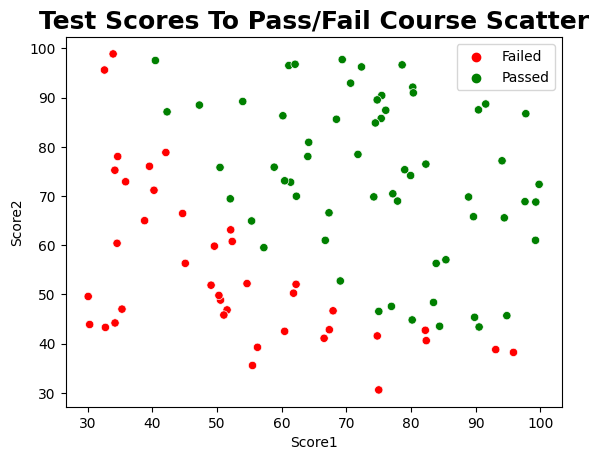

In [70]:
single_variable_model = LogisticRegressionModel(
    dataset=q1_df,
    epsilon=1e-5,
    asc_threshold=10)
single_variable_model.scatter_plot_dataset(title='Test Scores to Pass/Fail Course Scatter')

Sigmoid graph example

Text(0.5, 1.0, 'Sigmoid Function')

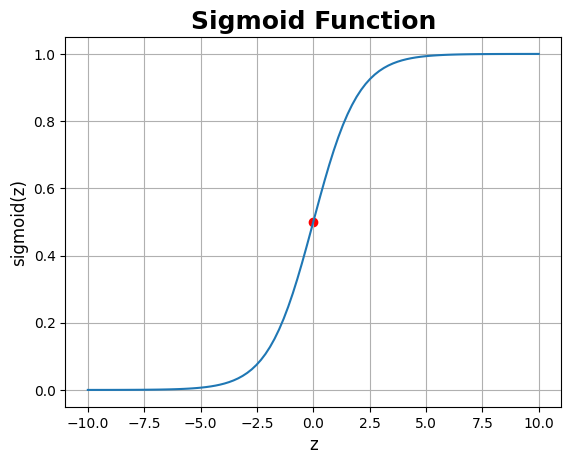

In [71]:
z = np.linspace(-10,10,100)
y = Utils.sigmoid(z)
plt.plot(z,y)
plt.grid()
plt.scatter(0, 0.5, color='red')
plt.xlabel('z', size=12)
plt.ylabel('sigmoid(z)', size=12)
plt.title('Sigmoid Function', size=18,  fontweight='bold')

Train Logistic Regression Model for data set #1

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\user\AppData\Local\Temp\ipykernel_8764\624936078.py:89: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array(gradient, dtype=np.float64).reshape(weights.shape[0], 1)


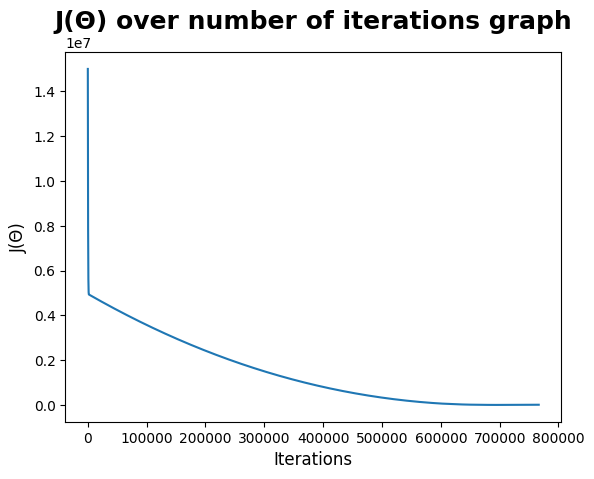

In [72]:
Utils.reset_variables()
single_variable_model.train_model(plot_cost_graph=True)

Plot decition boundary

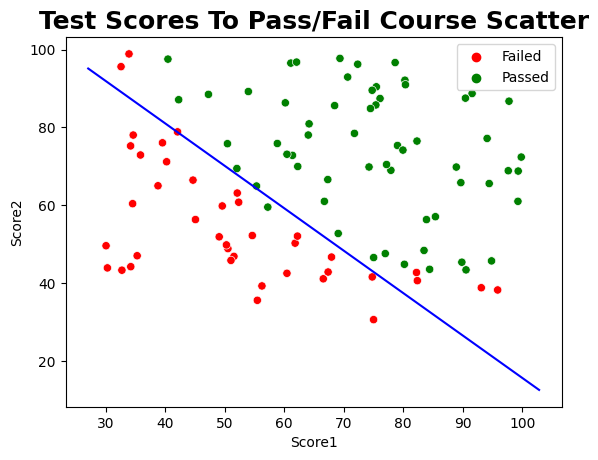

In [73]:
single_variable_model.scatter_plot_dataset(title='Test Scores to Pass/Fail Course Scatter')
single_variable_model.plot_decision_boundary_2D()

Model evaluation

In [74]:
Utils.reset_variables()
x = Utils.get_x_vals(q1_df)
y = Utils.get_y_vals(q1_df, x)
acc = single_variable_model.accuracy(x, y, threshold=0.5)
print(f'model has accuracy of {acc}%')

model has accuracy of 92.0%


New samples plot

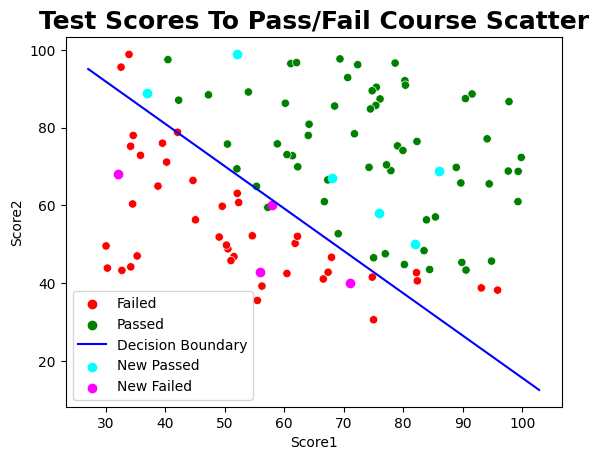

In [75]:
new_score_1 = np.random.randint(30, 100, 10)
new_score_2 = np.random.randint(30, 100, 10)
new_x = np.array(list(zip(np.ones(10), new_score_1, new_score_2)))
predictions = single_variable_model.predict(new_x, threshold=0.5)

ax = single_variable_model.scatter_plot_dataset(title='Test Scores to Pass/Fail Course Scatter')
single_variable_model.plot_decision_boundary_2D()

new_passed_x1 = []
new_passed_x2 = [] 
new_failed_x1 = []
new_failed_x2 = [] 

for x1, x2, p in zip(new_score_1, new_score_2, predictions):
    if p == 1:
        new_passed_x1.append(x1)
        new_passed_x2.append(x2)
    else:
        new_failed_x1.append(x1)
        new_failed_x2.append(x2)

ax.scatter(new_passed_x1, new_passed_x2, c='cyan', label='New Passed')
ax.scatter(new_failed_x1, new_failed_x2, c='magenta', label='New Failed')

legend_handles, _ = ax.get_legend_handles_labels()
plt.legend(legend_handles, ['Failed', 'Passed', 'Decision Boundary', 'New Passed', 'New Failed'])

# Q2: Logistic Regression with regularization

checking the shape of the mapfeature

In [23]:
Utils.reset_variables()
degree = 6
x,y = Utils.map_feature(q2_df, degree)
Utils.set_x_vals(x)
print(x.shape)
print(Utils.map_feature(q2_df, degree))

(118, 28)
(array([[ 1.00000000e+00,  5.12670000e-02,  6.99560000e-01, ...,
         6.29470940e-04,  8.58939846e-03,  1.17205992e-01],
       [ 1.00000000e+00, -9.27420000e-02,  6.84940000e-01, ...,
         1.89305413e-03, -1.39810280e-02,  1.03255971e-01],
       [ 1.00000000e+00, -2.13710000e-01,  6.92250000e-01, ...,
         1.04882142e-02, -3.39734512e-02,  1.10046893e-01],
       ...,
       [ 1.00000000e+00, -4.84450000e-01,  9.99270000e-01, ...,
         2.34007252e-01, -4.82684337e-01,  9.95627986e-01],
       [ 1.00000000e+00, -6.33640000e-03,  9.99270000e-01, ...,
         4.00328554e-05, -6.31330588e-03,  9.95627986e-01],
       [ 1.00000000e+00,  6.32650000e-01, -3.06120000e-02, ...,
         3.51474517e-07, -1.70067777e-08,  8.22905998e-10]]), ['x1^1 x2^0', 'x1^0 x2^1', 'x1^2 x2^0', 'x1^1 x2^1', 'x1^0 x2^2', 'x1^3 x2^0', 'x1^2 x2^1', 'x1^1 x2^2', 'x1^0 x2^3', 'x1^4 x2^0', 'x1^3 x2^1', 'x1^2 x2^2', 'x1^1 x2^3', 'x1^0 x2^4', 'x1^5 x2^0', 'x1^4 x2^1', 'x1^3 x2^2', 'x1^2 x2^

Scatter plot of the second data file 

<AxesSubplot:title={'center':'Microchip Test To Pass/Fail QA'}, xlabel='Score1', ylabel='Score2'>

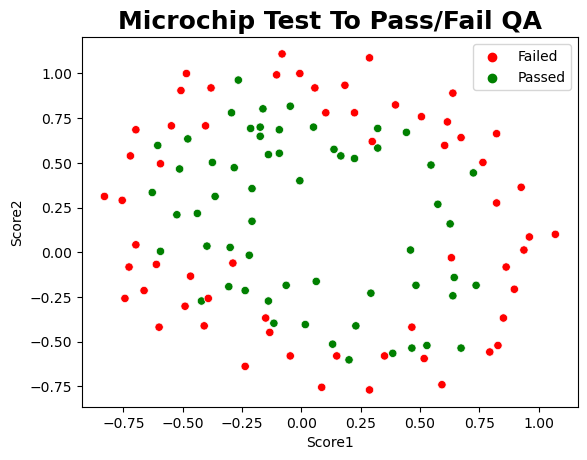

In [24]:
multi_variable_model = LogisticRegressionModel(
    dataset=q2_df,
    epsilon=1e-7,
    alpha=1,
    _lambda=0.001,
    use_dataset_dim=False)
multi_variable_model.scatter_plot_dataset(title='Microchip Test To Pass/Fail QA')

Train new model with regularization

c:\Users\galsa\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\galsa\AppData\Local\Temp\ipykernel_45276\9990921.py:96: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array(gradient, dtype=np.float64).reshape(weights.shape[0], 1)
C:\Users\galsa\AppData\Local\Temp\ipykernel_45276\9990921.py:10: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-z))


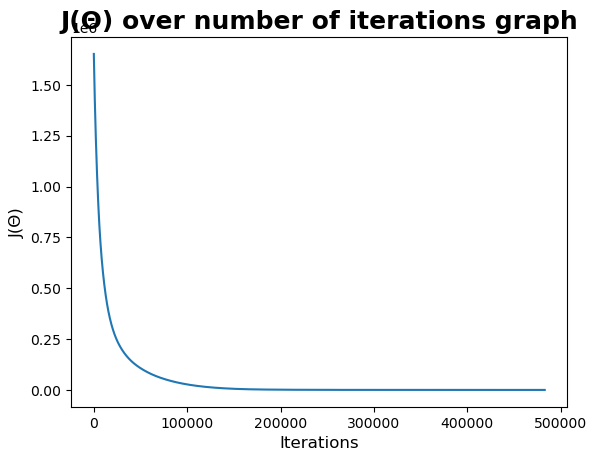

In [25]:
multi_variable_model.train_model(plot_cost_graph=True)

Plot decision boundary

In [1]:
ax = multi_variable_model.scatter_plot_dataset(title='Microchip Test To Pass/Fail QA')
multi_variable_model.plot_decision_boundary_poly(degree, ax)

NameError: name 'multi_variable_model' is not defined

Test model accuracy

In [36]:
y = Utils.get_y_vals(q2_df, x)
acc = multi_variable_model.accuracy(x, y, threshold=0.5)
print(f'model has accuracy of {acc}%')

model has accuracy of 86.44%


new points

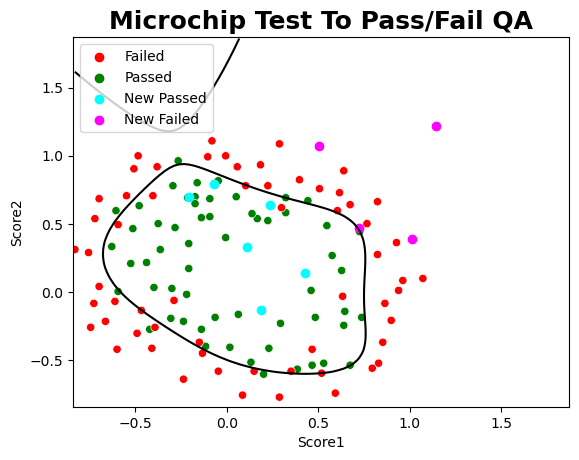

In [39]:
factor = 0.5
new_score_1 = np.random.uniform(np.min(x) + factor, np.max(x) - factor, 10)
new_score_2 = np.random.uniform(np.min(x) + factor, np.max(x) - factor, 10)

df = pd.DataFrame({'New Score 1':new_score_1, 'New Score 2':new_score_2})
x_poly, _ = Utils.map_feature(df, degree)
predictions = multi_variable_model.predict(x_poly, threshold=0.5)

ax = multi_variable_model.scatter_plot_dataset(title='Microchip Test To Pass/Fail QA')
multi_variable_model.plot_decision_boundary_poly(degree, ax)

new_passed_x1 = []
new_passed_x2 = [] 
new_failed_x1 = []
new_failed_x2 = [] 

for x1, x2, p in zip(new_score_1, new_score_2, predictions):
    if p == 1:
        new_passed_x1.append(x1)
        new_passed_x2.append(x2)
    else:
        new_failed_x1.append(x1)
        new_failed_x2.append(x2)

ax.scatter(new_passed_x1, new_passed_x2, c='cyan', label='New Passed')
ax.scatter(new_failed_x1, new_failed_x2, c='magenta', label='New Failed')

legend_handles, _ = ax.get_legend_handles_labels()
plt.legend(legend_handles, ['Failed', 'Passed', 'New Passed', 'New Failed'])